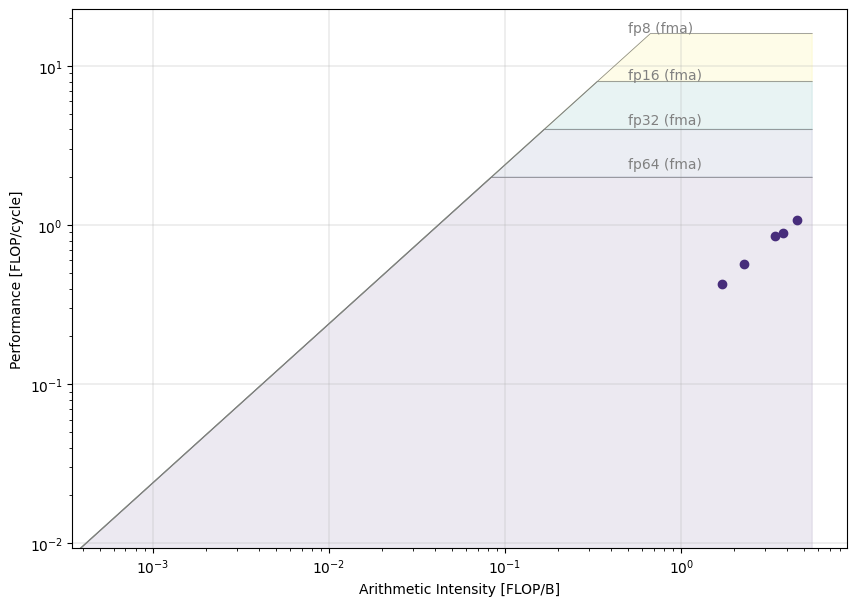

In [5]:
import io
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

with open("data.csv") as f:
    df = pd.read_csv(f, sep=",", skipinitialspace=True)

cluster_tcdm_banks = 32  # Number of TCDM banks per cluster
cc_n_streams = 3  # Number of streams available for a core complex
tcdm_transaction_size = 8  # TCDM transaction transfer size (B)
cluster_peak_bandwidth = (
    cluster_tcdm_banks * tcdm_transaction_size
)  # Peak memory bandwidth (B/cycle)
cc_attainable_bandwidth = (
    cc_n_streams * tcdm_transaction_size
)  # Attainable memory bandwidth by a single core complex (B/cycle)
# Note: the previous number is probably incomplete since we are missing
# the cc > snitch own LSU and the cc > fpss own LSU. It should probably be
# incremented by 2 (no. of additional LSUs) * tcdm_transaction_size.
# Of course, if any of those additional LSUs are operating on data types
# whose size is smaller than tcdm_transaction_size, transacted data is
# going to be wasted.
# FIXME: take data type transacted by additional FPUs into account

nloads = df["fpss_loads"] + df["snitch_loads"]
df["intensity"] = df["fpss_fpu_issues"] / (nloads * tcdm_transaction_size)
df["performance"] = df["fpss_fpu_issues"] / df["cycles"]

peak_bandwidth = cc_n_streams * tcdm_transaction_size  # B/cycle

# For each data type: Theoretical peak performance (FLOP/cycle)
dtypes = {
    "fp8": 16,
    "fp16": 8,
    "fp32": 4,
    "fp64": 2,
}

cmap = matplotlib.colormaps["viridis"]  # should be a progressive palette
norm = matplotlib.colors.Normalize(vmin=0, vmax=max(dtypes.values()))
color = {
    "fp8": cmap(norm(dtypes["fp8"])),
    "fp16": cmap(norm(dtypes["fp16"])),
    "fp32": cmap(norm(dtypes["fp32"])),
    "fp64": cmap(norm(dtypes["fp64"])),
}

fig, ax = plt.subplots(figsize=(10, 7))

ax.set_xscale("log")
ax.set_yscale("log")

# Set the range for both axes
# plt.xlim(0, benchmarks["operational_intensity"].max() + 1)
# plt.ylim(0, max(dtypes.values()) + 1)

# Calculate the roofline boundaries
x = np.linspace(0, df["intensity"].max() + 1, 10000)
y = {
    dtype: np.minimum(x * cc_attainable_bandwidth, peak_performance)
    for dtype, peak_performance in dtypes.items()
}

# Plot the rooflines
for dtype, y_roofline in y.items():
    plt.plot(x, y_roofline, color="grey", linestyle="-", linewidth=0.5)

# Add roofline labels
plt.text(0.5, dtypes["fp64"] + 0.3, "fp64 (fma)", color="grey", fontsize=10)
plt.text(0.5, dtypes["fp32"] + 0.3, "fp32 (fma)", color="grey", fontsize=10)
plt.text(0.5, dtypes["fp16"] + 0.3, "fp16 (fma)", color="grey", fontsize=10)
plt.text(0.5, dtypes["fp8"] + 0.3, "fp8 (fma)", color="grey", fontsize=10)

# Fill the areas between the rooflines with different colors
plt.fill_between(x, 0, y["fp64"], color=color["fp64"], alpha=0.1)
plt.fill_between(x, y["fp64"], y["fp32"], color=color["fp32"], alpha=0.1)
plt.fill_between(x, y["fp32"], y["fp16"], color=color["fp16"], alpha=0.1)
plt.fill_between(x, y["fp16"], y["fp8"], color=color["fp8"], alpha=0.1)

# Plot the benchmarks
for _, row in df.iterrows():
    plt.plot(
        row["intensity"], row["performance"], "o", color=color[row["dtype"]]
    )

# Set logarithmic scale for both axes
# plt.set_xscale("log")
# plt.yscale("log")

# Add labels and titles
plt.xlabel("Arithmetic Intensity [FLOP/B]")
plt.ylabel("Performance [FLOP/cycle]")
# plt.title("Roofline Plot")

# # Add legend
# plt.legend([benchmark[0] for benchmark in benchmarks])

# Show the plot
plt.grid(True, linewidth=0.3)
plt.savefig("images/roofline.png")
plt.savefig("images/roofline.pdf")
plt.show()